
<div class="alert alert-info">

**This is a fixed-text formatted version of a Jupyter notebook**

- Try online[![Binder](https://static.mybinder.org/badge.svg)](https://mybinder.org/v2/gh/gammapy/gammapy-webpage/v0.20.1?urlpath=lab/tree/tutorials/api/datasets.ipynb)
- You may download all the notebooks as a [tar file](../../_downloads/notebooks-0.20.1.tar).
- **Source files:**
[datasets.ipynb](../../_static/notebooks/datasets.ipynb) |
[datasets.py](../../_static/notebooks/datasets.py)
</div>


# Datasets - Reduced data, IRFs, models 

## Introduction

`gammapy.datasets` are a crucial part of the gammapy API. `datasets` constitute `DL4` data - binned counts, IRFs, models and the associated likelihoods. `Datasets` from the end product of the `makers` stage, see [makers notebook](makers.ipynb), and are passed on to the `Fit` or estimator classes for modelling and fitting purposes.

To find the different types of `Dataset` that are supported see [Datasets home](../../user-guide/datasets/index.rst#Types-of-supported-datasets)


## Setup

In [1]:
import numpy as np
import astropy.units as u
from astropy.time import Time
from regions import CircleSkyRegion
from astropy.coordinates import SkyCoord
from gammapy.datasets import (
    MapDataset,
    SpectrumDataset,
    SpectrumDatasetOnOff,
    Datasets,
    FluxPointsDataset,
)
from gammapy.data import DataStore, GTI
from gammapy.maps import WcsGeom, RegionGeom, MapAxes, MapAxis, Map
from gammapy.modeling.models import (
    SkyModel,
    PowerLawSpectralModel,
    FoVBackgroundModel,
)
from gammapy.estimators import FluxPoints
from gammapy.utils.scripts import make_path

In [2]:
%matplotlib inline

## MapDataset

The counts, exposure, background, masks, and IRF maps are bundled together in a data structure named `MapDataset`. While the `counts`, and `background` maps are binned in reconstructed energy and must have the same geometry, the IRF maps can have a different spatial (coarsely binned and larger) geometry and spectral range (binned in true energies). It is usually recommended that the true energy bin should be larger and more finely sampled and the reco energy bin.

### Creating an empty dataset 

An empty `MapDataset` can be directly instantiated from any `WcsGeom` object:

In [3]:
energy_axis = MapAxis.from_energy_bounds(
    1, 10, nbin=11, name="energy", unit="TeV"
)

geom = WcsGeom.create(
    skydir=(83.63, 22.01),
    axes=[energy_axis],
    width=5 * u.deg,
    binsz=0.05 * u.deg,
    frame="icrs",
)

dataset_empty = MapDataset.create(geom=geom, name="my-dataset")

It is good practice to define a name for the dataset, such that you can identify it later by name. However if you define a name it **must** be unique. Now we can already print the dataset:

In [4]:
print(dataset_empty)

MapDataset
----------

  Name                            : my-dataset 

  Total counts                    : 0 
  Total background counts         : 0.00
  Total excess counts             : 0.00

  Predicted counts                : 0.00
  Predicted background counts     : 0.00
  Predicted excess counts         : nan

  Exposure min                    : 0.00e+00 m2 s
  Exposure max                    : 0.00e+00 m2 s

  Number of total bins            : 110000 
  Number of fit bins              : 0 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : nan

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0




The printout shows the key summary information of the dataset, such as total counts, fit statistics, model information etc.

`MapDataset.from_geom` has additional keywords, that can be used to define the binning of the IRF related maps:

In [5]:
# choose a different true energy binning for the exposure, psf and edisp
energy_axis_true = MapAxis.from_energy_bounds(
    0.1, 100, nbin=11, name="energy_true", unit="TeV", per_decade=True
)

# choose a different rad axis binning for the psf
rad_axis = MapAxis.from_bounds(0, 5, nbin=50, unit="deg", name="rad")

gti = GTI.create(0 * u.s, 1000 * u.s)

dataset_empty = MapDataset.create(
    geom=geom,
    energy_axis_true=energy_axis_true,
    rad_axis=rad_axis,
    binsz_irf=0.1,
    gti=gti,
    name="dataset-empty",
)

To see the geometry of each map, we can use:

In [6]:
dataset_empty.geoms

{'geom': WcsGeom
 
 	axes       : ['lon', 'lat', 'energy']
 	shape      : (100, 100, 11)
 	ndim       : 3
 	frame      : icrs
 	projection : CAR
 	center     : 83.6 deg, 22.0 deg
 	width      : 5.0 deg x 5.0 deg
 	wcs ref    : 83.6 deg, 22.0 deg,
 'geom_exposure': WcsGeom
 
 	axes       : ['lon', 'lat', 'energy_true']
 	shape      : (100, 100, 33)
 	ndim       : 3
 	frame      : icrs
 	projection : CAR
 	center     : 83.6 deg, 22.0 deg
 	width      : 5.0 deg x 5.0 deg
 	wcs ref    : 83.6 deg, 22.0 deg,
 'geom_psf': WcsGeom
 
 	axes       : ['lon', 'lat', 'rad', 'energy_true']
 	shape      : (50, 50, 50, 33)
 	ndim       : 4
 	frame      : icrs
 	projection : CAR
 	center     : 83.6 deg, 22.0 deg
 	width      : 5.0 deg x 5.0 deg
 	wcs ref    : 83.6 deg, 22.0 deg,
 'geom_edisp': WcsGeom
 
 	axes       : ['lon', 'lat', 'energy', 'energy_true']
 	shape      : (50, 50, 11, 33)
 	ndim       : 4
 	frame      : icrs
 	projection : CAR
 	center     : 83.6 deg, 22.0 deg
 	width      : 5.0 deg x 

Another way to create a `MapDataset` is to just read an existing one from a FITS file:

In [7]:
dataset_cta = MapDataset.read(
    "$GAMMAPY_DATA/cta-1dc-gc/cta-1dc-gc.fits.gz", name="dataset-cta"
)

In [8]:
print(dataset_cta)

MapDataset
----------

  Name                            : dataset-cta 

  Total counts                    : 104317 
  Total background counts         : 91507.70
  Total excess counts             : 12809.30

  Predicted counts                : 91507.69
  Predicted background counts     : 91507.70
  Predicted excess counts         : nan

  Exposure min                    : 6.28e+07 m2 s
  Exposure max                    : 1.90e+10 m2 s

  Number of total bins            : 768000 
  Number of fit bins              : 691680 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : nan

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0




## Accessing contents of a dataset

To further explore the contents of a `Dataset`, you can use e.g. `.info_dict()`

In [9]:
# For a quick info, use
dataset_cta.info_dict()

{'name': 'dataset-cta',
 'counts': 104317,
 'excess': 12809.3046875,
 'sqrt_ts': 41.41009347393684,
 'background': 91507.6953125,
 'npred': 91507.68628538586,
 'npred_background': 91507.6953125,
 'npred_signal': nan,
 'exposure_min': <Quantity 62842028. m2 s>,
 'exposure_max': <Quantity 1.90242058e+10 m2 s>,
 'livetime': <Quantity 5292.00010298 s>,
 'ontime': <Quantity 5400. s>,
 'counts_rate': <Quantity 19.71220672 1 / s>,
 'background_rate': <Quantity 17.29170324 1 / s>,
 'excess_rate': <Quantity 2.42050348 1 / s>,
 'n_bins': 768000,
 'n_fit_bins': 691680,
 'stat_type': 'cash',
 'stat_sum': nan}

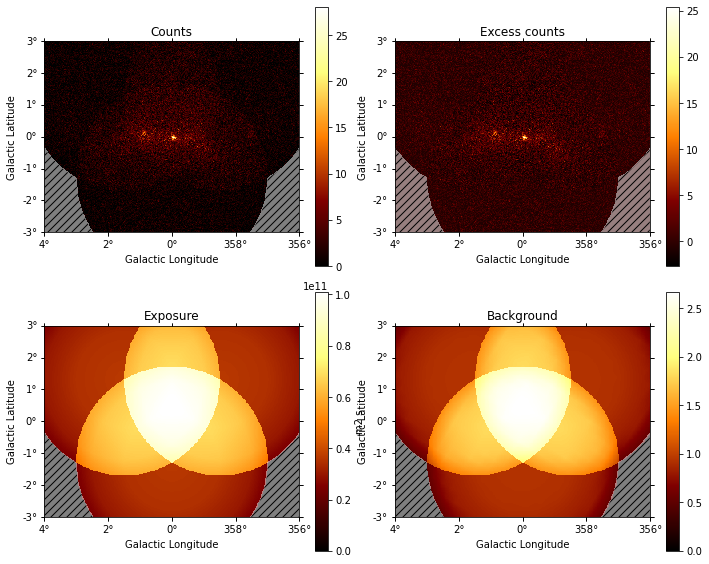

In [10]:
# For a quick view, use
dataset_cta.peek()

And access individual maps like:

<WCSAxesSubplot:xlabel='Galactic Longitude', ylabel='Galactic Latitude'>

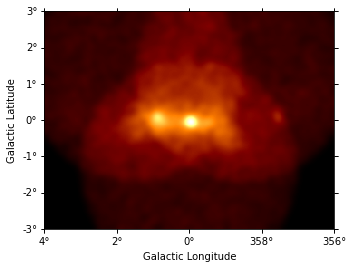

In [11]:
counts_image = dataset_cta.counts.sum_over_axes()
counts_image.smooth("0.1 deg").plot()

Of course you can also access IRF related maps, e.g. the psf as `PSFMap`:

In [12]:
dataset_cta.psf

And use any method on the `PSFMap` object:

<AxesSubplot:xlabel='Energy (TeV)', ylabel='Containment radius (deg)'>

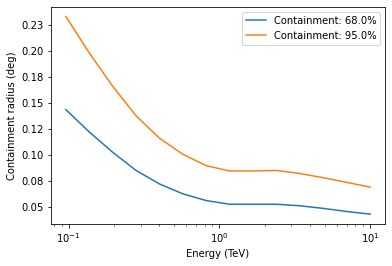

In [13]:
dataset_cta.psf.plot_containment_radius_vs_energy()

<AxesSubplot:xlabel='True Energy [TeV]', ylabel='Energy [TeV]'>

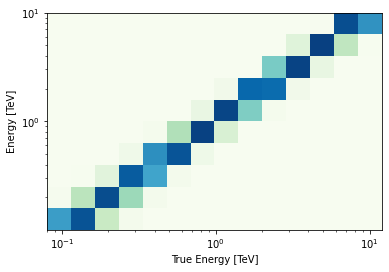

In [14]:
edisp_kernel = dataset_cta.edisp.get_edisp_kernel()
edisp_kernel.plot_matrix()

The `MapDataset` typically also contains the information on the residual hadronic background, stored in `MapDataset.background` as a map:

In [15]:
dataset_cta.background

WcsNDMap

	geom  : WcsGeom 
 	axes  : ['lon', 'lat', 'energy']
	shape : (320, 240, 10)
	ndim  : 3
	unit  : 
	dtype : >f4

As a next step we define a minimal model on the dataset using the `.models` setter:

In [16]:
model = SkyModel.create("pl", "point", name="gc")
model.spatial_model.position = SkyCoord("0d", "0d", frame="galactic")
model_bkg = FoVBackgroundModel(dataset_name="dataset-cta")

dataset_cta.models = [model, model_bkg]

Assigning models to datasets is covered in more detail in the [Modeling notebook](model_management.ipynb). Printing the dataset will now show the mode components:

In [17]:
print(dataset_cta)

MapDataset
----------

  Name                            : dataset-cta 

  Total counts                    : 104317 
  Total background counts         : 91507.70
  Total excess counts             : 12809.30

  Predicted counts                : 91719.65
  Predicted background counts     : 91507.69
  Predicted excess counts         : 211.96

  Exposure min                    : 6.28e+07 m2 s
  Exposure max                    : 1.90e+10 m2 s

  Number of total bins            : 768000 
  Number of fit bins              : 691680 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : 424648.57

  Number of models                : 2 
  Number of parameters            : 8
  Number of free parameters       : 5

  Component 0: SkyModel
  
    Name                      : gc
    Datasets names            : None
    Spectral model type       : PowerLawSpectralModel
    Spatial  model type       : PointSpatialModel
    Temporal model type       : 
    Parameters:
      index 

Now we can use `.npred()` to get a map of the total predicted counts of the model:

<WCSAxesSubplot:xlabel='Galactic Longitude', ylabel='Galactic Latitude'>

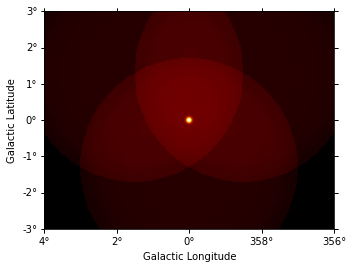

In [18]:
npred = dataset_cta.npred()
npred.sum_over_axes().plot()

To get the predicted counts from an individual model component we can use:

<WCSAxesSubplot:xlabel='Galactic Longitude', ylabel='Galactic Latitude'>

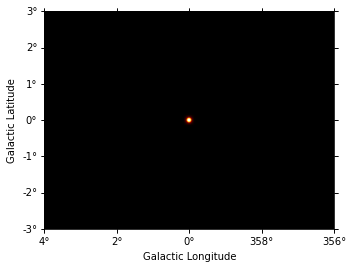

In [19]:
npred_source = dataset_cta.npred_signal(model_name="gc")
npred_source.sum_over_axes().plot()

`MapDataset.background` contains the background map computed from the IRF. Internally it will be combined with a `FoVBackgroundModel`, to allow for adjusting the backgroun model during a fit. To get the model corrected background, one can use `dataset.npred_background()`. 

<WCSAxesSubplot:xlabel='Galactic Longitude', ylabel='Galactic Latitude'>

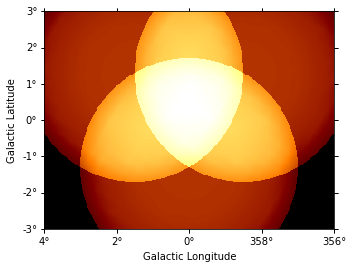

In [20]:
npred_background = dataset_cta.npred_background()
npred_background.sum_over_axes().plot()

### Using masks

There are two masks that can be set on a `Dataset`, `mask_safe` and `mask_fit`. 

- The `mask_safe` is computed during the data reduction process according to the specified selection cuts, and should not be changed by the user.
- During modelling and fitting, the user might want to additionally ignore some parts of a reduced dataset, e.g. to restrict the fit to a specific energy range or to ignore parts of the region of interest. This should be done by applying the `mask_fit`. To see details of applying masks, please refer to [Masks-for-fitting](mask_maps.ipynb#Masks-for-fitting:-mask_fit)

Both the `mask_fit` and `mask_safe` must have the safe `geom` as the `counts` and `background` maps.

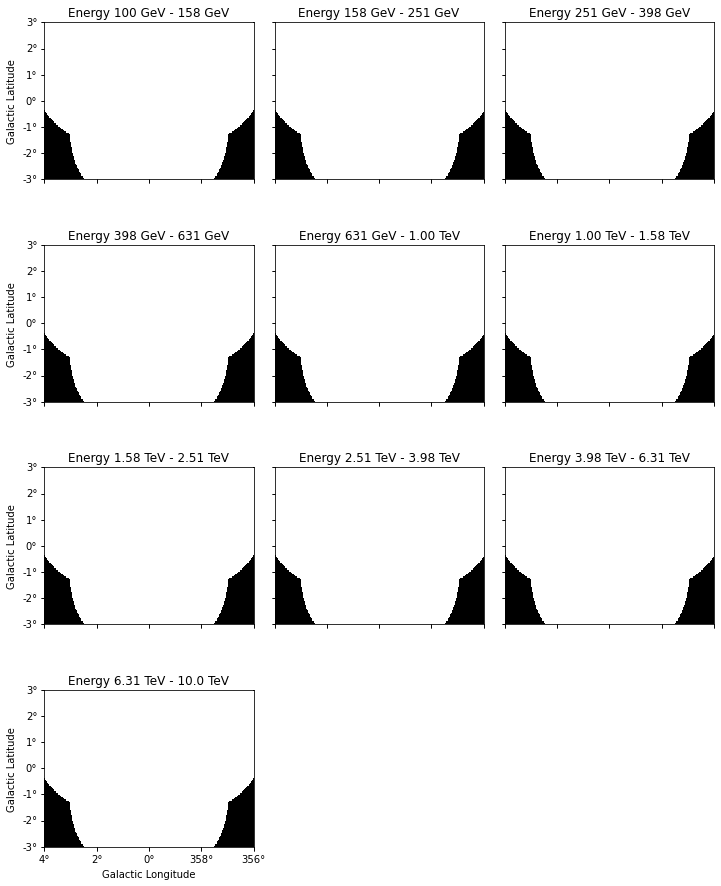

In [21]:
# eg: to see the safe data range
dataset_cta.mask_safe.plot_grid();

In addition it is possible to define a custom `mask_fit`:

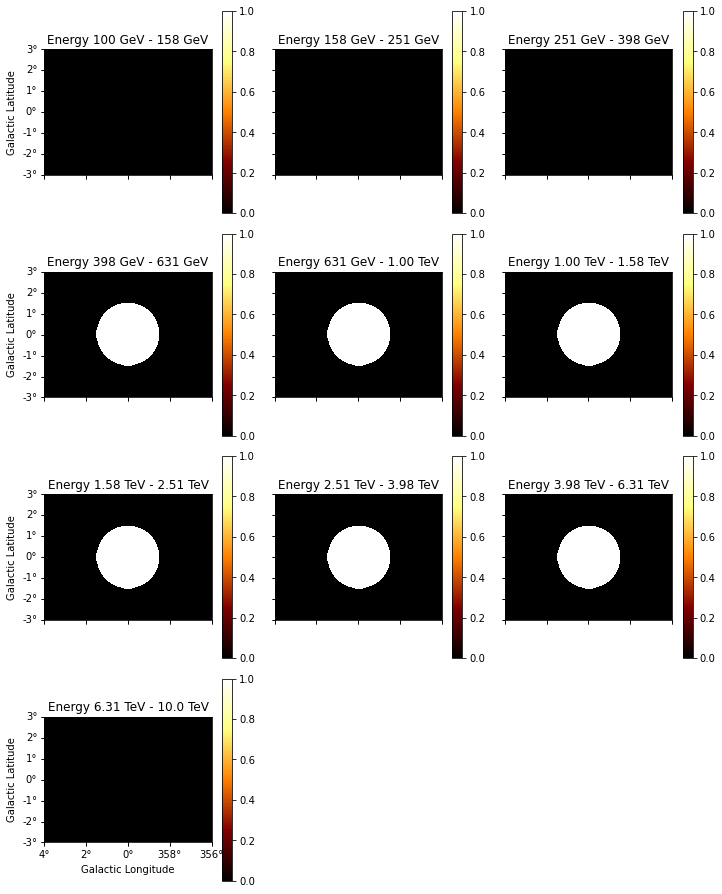

In [22]:
# To apply a mask fit - in enegy and space
region = CircleSkyRegion(SkyCoord("0d", "0d", frame="galactic"), 1.5 * u.deg)

geom = dataset_cta.counts.geom

mask_space = geom.region_mask([region])
mask_energy = geom.energy_mask(0.3 * u.TeV, 8 * u.TeV)
dataset_cta.mask_fit = mask_space & mask_energy
dataset_cta.mask_fit.plot_grid(vmin=0, vmax=1, add_cbar=True);

To access the energy range defined by the mask you can use:
- `dataset.energy_range_safe` : energy range definedby the `mask_safe`
- `dataset.energy_range_fit` : energy range defined by the `mask_fit`
- `dataset.energy_range` : the final energy range used in likelihood computation

These methods return two maps, with the `min` and `max` energy values at each spatial pixel

In [23]:
e_min, e_max = dataset_cta.energy_range

<WCSAxesSubplot:xlabel='Galactic Longitude', ylabel='Galactic Latitude'>

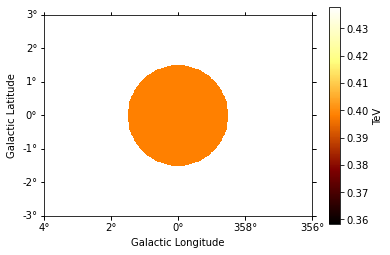

In [24]:
# To see the lower energy threshold at each point
e_min.plot(add_cbar=True)

<WCSAxesSubplot:xlabel='Galactic Longitude', ylabel='Galactic Latitude'>

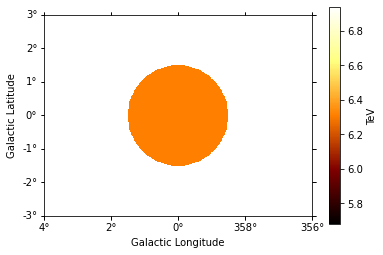

In [25]:
# To see the lower energy threshold at each point
e_max.plot(add_cbar=True)

Just as for `Map` objects it is possible to cutout a whole `MapDataset`, which will perform the cutout for all maps in parallel.Optionally one can provide a new name to the resulting dataset:

In [26]:
cutout = dataset_cta.cutout(
    position=SkyCoord("0d", "0d", frame="galactic"),
    width=2 * u.deg,
    name="cta-cutout",
)

<WCSAxesSubplot:xlabel='Galactic Longitude', ylabel='Galactic Latitude'>

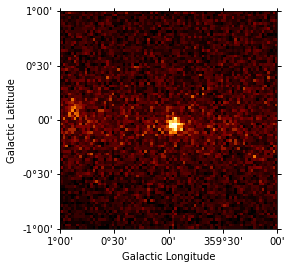

In [27]:
cutout.counts.sum_over_axes().plot()

It is also possible to slice a `MapDataset` in energy:

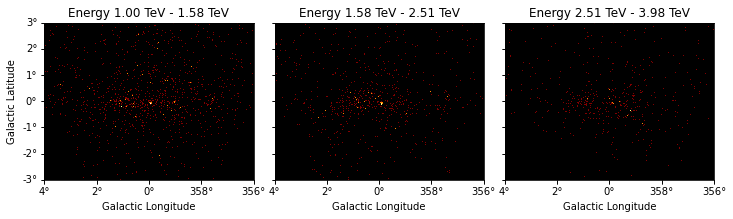

In [28]:
sliced = dataset_cta.slice_by_energy(
    energy_min=1 * u.TeV, energy_max=5 * u.TeV, name="slice-energy"
)
sliced.counts.plot_grid();

The same operation will be applied to all other maps contained in the datasets such as `mask_fit`:

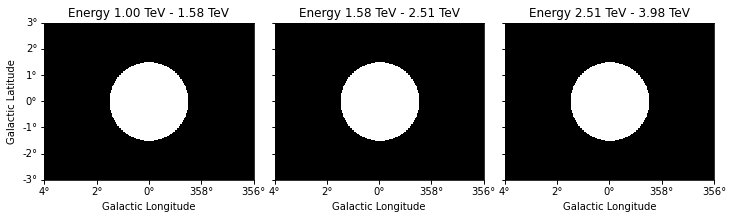

In [29]:
sliced.mask_fit.plot_grid();

### Resampling datasets

It can often be useful to coarsely rebin an initially computed datasets by a specified factor. This can be done in either spatial or energy axes:

<WCSAxesSubplot:xlabel='Galactic Longitude', ylabel='Galactic Latitude'>

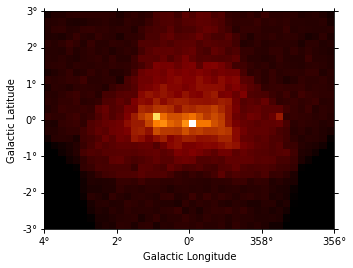

In [30]:
downsampled = dataset_cta.downsample(factor=8)
downsampled.counts.sum_over_axes().plot()

And the same downsampling process is possible along the energy axis:

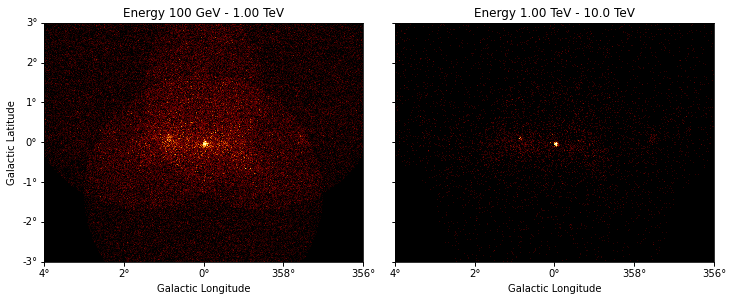

In [31]:
downsampled_energy = dataset_cta.downsample(
    factor=5, axis_name="energy", name="downsampled-energy"
)
downsampled_energy.counts.plot_grid();

In the printout one can see that the actual number of counts is preserved during the downsampling:

In [32]:
print(downsampled_energy, dataset_cta)

MapDataset
----------

  Name                            : downsampled-energy 

  Total counts                    : 104317 
  Total background counts         : 91507.69
  Total excess counts             : 12809.31

  Predicted counts                : 91507.69
  Predicted background counts     : 91507.69
  Predicted excess counts         : nan

  Exposure min                    : 6.28e+07 m2 s
  Exposure max                    : 1.90e+10 m2 s

  Number of total bins            : 153600 
  Number of fit bins              : 22608 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : nan

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0

 MapDataset
----------

  Name                            : dataset-cta 

  Total counts                    : 104317 
  Total background counts         : 91507.70
  Total excess counts             : 12809.30

  Predicted counts                : 91719.65
  Predicted b

We can also resample the finer binned datasets to an arbitrary coarser energy binning using:

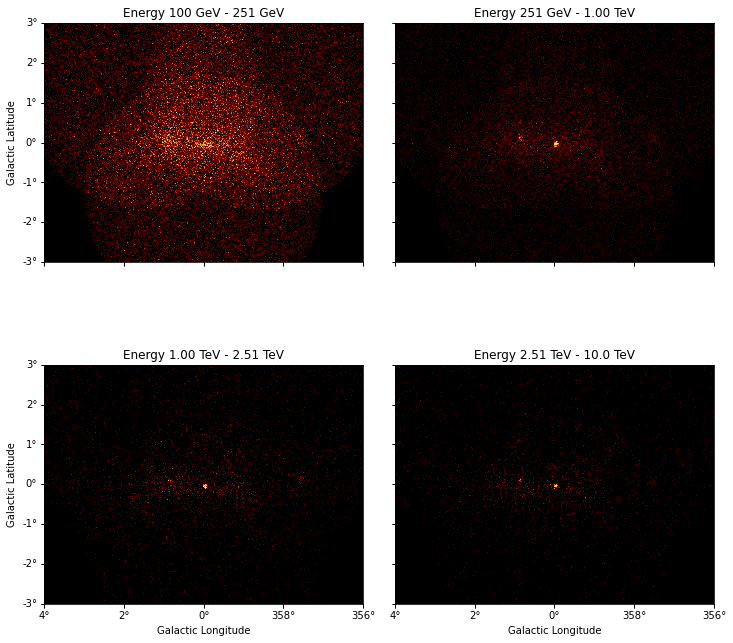

In [33]:
energy_axis_new = MapAxis.from_energy_edges([0.1, 0.3, 1, 3, 10] * u.TeV)
resampled = dataset_cta.resample_energy_axis(energy_axis=energy_axis_new)
resampled.counts.plot_grid(ncols=2);

To squash the whole dataset into a single energy bin there is the `.to_image()` convenience method:

<WCSAxesSubplot:xlabel='Galactic Longitude', ylabel='Galactic Latitude'>

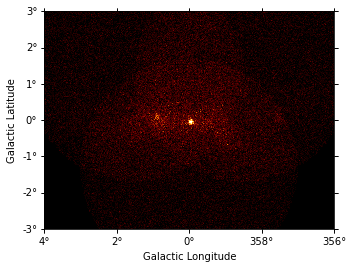

In [34]:
dataset_image = dataset_cta.to_image()
dataset_image.counts.plot()

## SpectrumDataset

`SpectrumDataset` inherits from a `MapDataset`, and is specially adapted for 1D spectral analysis, and uses a `RegionGeom` instead of a `WcsGeom`. 
A `MapDatset` can be converted to a `SpectrumDataset`, by summing the `counts` and `background` inside the `on_region`, which can then be used for classical spectral analysis. Containment correction is feasible only for circular regions.

In [35]:
region = CircleSkyRegion(
    SkyCoord(0, 0, unit="deg", frame="galactic"), 0.5 * u.deg
)
spectrum_dataset = dataset_cta.to_spectrum_dataset(
    region, containment_correction=True, name="spectrum-dataset"
)

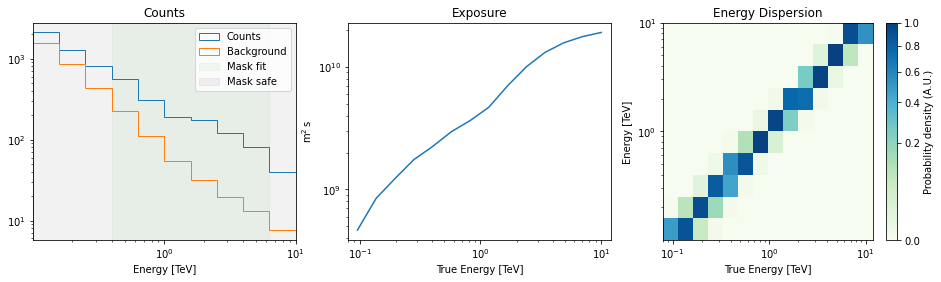

In [36]:
# For a quick look
spectrum_dataset.peek();

A `MapDataset` can also be integrated over the `on_region` to create a `MapDataset` with a `RegionGeom`. Complex regions can be handled and since the full IRFs are used, containment correction is not required. 

In [37]:
reg_dataset = dataset_cta.to_region_map_dataset(
    region, name="region-map-dataset"
)
print(reg_dataset)

MapDataset
----------

  Name                            : region-map-dataset 

  Total counts                    : 5644 
  Total background counts         : 3323.66
  Total excess counts             : 2320.34

  Predicted counts                : 3323.66
  Predicted background counts     : 3323.66
  Predicted excess counts         : nan

  Exposure min                    : 4.66e+08 m2 s
  Exposure max                    : 1.89e+10 m2 s

  Number of total bins            : 10 
  Number of fit bins              : 6 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : nan

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0




## FluxPointsDataset

`FluxPointsDataset` is a `Dataset` container for precomputed flux points, which can be then used in fitting.
`FluxPointsDataset` cannot be read directly, but should be read through `FluxPoints`, with an additional `SkyModel`. Similarly, `FluxPointsDataset.write` only saves the `data` component to disk. 

In [38]:
flux_points = FluxPoints.read(
    "$GAMMAPY_DATA/tests/spectrum/flux_points/diff_flux_points.fits"
)
model = SkyModel(spectral_model=PowerLawSpectralModel(index=2.3))
fp_dataset = FluxPointsDataset(data=flux_points, models=model)

No reference model set for FluxMaps. Assuming point source with E^-2 spectrum.


<AxesSubplot:xlabel='Energy [MeV]', ylabel='e2dnde [erg / (cm2 s)]'>

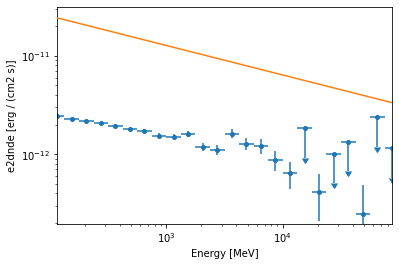

In [39]:
fp_dataset.plot_spectrum()

The masks on `FluxPointsDataset` are `np.array` and the data is a `FluxPoints` object. The `mask_safe`, by default, masks the upper limit points

In [40]:
fp_dataset.mask_safe  # Note: the mask here is simply a numpy array

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True, False,
        True, False, False,  True, False, False])

In [41]:
fp_dataset.data  # is a `FluxPoints` object

In [42]:
fp_dataset.data_shape()  # number of data points

(24,)

For an example of fitting `FluxPoints`, see [flux point fitting](../analysis/1D/sed_fitting.ipynb), and can be used for catalog objects, eg see [catalog notebook](catalog.ipynb)

## Datasets

`Datasets` are a collection of `Dataset` objects. They can be of the same type, or of different types, eg: mix of `FluxPointDataset`, `MapDataset` and `SpectrumDataset`. 

For modelling and fitting of a list of `Dataset` objects, you can either
- Do a joint fitting of all the datasets together
- Stack the datasets together, and then fit them.

`Datasets` is a convenient tool to handle joint fitting of simultaneous datasets. As an example, please see the [joint fitting tutorial](../analysis/3D/analysis_mwl.ipynb)

To see how stacking is performed, please see [Implementation of stacking](../../user-guide/datasets/index.rst#stacking-multiple-datasets)

To create a `Datasets` object, pass a list of `Dataset` on init, eg

In [43]:
datasets = Datasets([dataset_empty, dataset_cta])

In [44]:
print(datasets)

Datasets
--------

Dataset 0: 

  Type       : MapDataset
  Name       : dataset-empty
  Instrument : 
  Models     : 

Dataset 1: 

  Type       : MapDataset
  Name       : dataset-cta
  Instrument : 
  Models     : ['gc', 'dataset-cta-bkg']




If all the datasets have the same type we can also print an info table, collectiong all the information from the individual casll to `Dataset.info_dict()`:

In [45]:
datasets.info_table()  # quick info of all datasets

name,counts,excess,sqrt_ts,background,npred,npred_background,npred_signal,exposure_min,exposure_max,livetime,ontime,counts_rate,background_rate,excess_rate,n_bins,n_fit_bins,stat_type,stat_sum
,,,,,,,,m2 s,m2 s,s,s,1 / s,1 / s,1 / s,,,,
str13,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,int64,str4,float64
dataset-empty,0,0.0,0.0,0.0,0.0,0.0,nan,0.0,0.0,nan,999.9999999999997,nan,nan,nan,110000,0,cash,nan
dataset-cta,104317,12809.3046875,41.41009347393684,91507.6953125,91719.64810194193,91507.68628538586,211.96181655608592,62842028.0,19024205824.0,5292.0001029780005,5400.0,19.712206721480793,17.291703237308198,2.4205034841725985,768000,67824,cash,44317.661091269125


In [46]:
datasets.names  # unique name of each dataset

['dataset-empty', 'dataset-cta']

We can access individual datasets in  `Datasets` object by name: 

In [47]:
datasets["dataset-empty"]  # extracts the first dataset

Or by index:

In [48]:
datasets[0]

Other list type operations work as well such as:

In [49]:
# Use python list convention to remove/add datasets, eg:
datasets.remove("dataset-empty")
datasets.names

['dataset-cta']

Or

In [50]:
datasets.append(spectrum_dataset)
datasets.names

['dataset-cta', 'spectrum-dataset']

Let's create a list of spectrum datasets to illustrate some more functionality:

In [51]:
datasets = Datasets()

path = make_path("$GAMMAPY_DATA/joint-crab/spectra/hess")

for filename in path.glob("pha_*.fits"):
    dataset = SpectrumDatasetOnOff.read(filename)
    datasets.append(dataset)

In [52]:
print(datasets)

Datasets
--------

Dataset 0: 

  Type       : SpectrumDatasetOnOff
  Name       : 23559
  Instrument : 
  Models     : 

Dataset 1: 

  Type       : SpectrumDatasetOnOff
  Name       : 23523
  Instrument : 
  Models     : 

Dataset 2: 

  Type       : SpectrumDatasetOnOff
  Name       : 23592
  Instrument : 
  Models     : 

Dataset 3: 

  Type       : SpectrumDatasetOnOff
  Name       : 23526
  Instrument : 
  Models     : 




Now we can stack all datasets using `.stack_reduce()`:

In [53]:
stacked = datasets.stack_reduce(name="stacked")
print(stacked)

SpectrumDatasetOnOff
--------------------

  Name                            : stacked 

  Total counts                    : 459 
  Total background counts         : 27.50
  Total excess counts             : 431.50

  Predicted counts                : 45.27
  Predicted background counts     : 45.27
  Predicted excess counts         : nan

  Exposure min                    : 2.13e+06 m2 s
  Exposure max                    : 2.63e+09 m2 s

  Number of total bins            : 80 
  Number of fit bins              : 43 

  Fit statistic type              : wstat
  Fit statistic value (-2 log(L)) : 1530.36

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0

  Total counts_off                : 645 
  Acceptance                      : 80 
  Acceptance off                  : 2016 



Or slice all datasets by a given energy range:

In [54]:
datasets_sliced = datasets.slice_by_energy(
    energy_min="1 TeV", energy_max="10 TeV"
)
print(datasets_sliced.energy_ranges)

(<Quantity [1.e+09, 1.e+09, 1.e+09, 1.e+09] keV>, <Quantity [1.e+10, 1.e+10, 1.e+10, 1.e+10] keV>)
